<a href="https://colab.research.google.com/github/IamShivamJaiswal/OCR_metadata_extraction/blob/master/OCR_metadata_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Tesseract for unix system

In [1]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


## Install pytesseract

In [2]:
!pip install pytesseract

## Import library

In [0]:
import pytesseract
from PIL import Image
import cv2
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import pandas as pd

## Download the test images

In [4]:
!wget https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_2/samp_fmi_2-3.png
!wget https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_1/samp_fmi_1-3.png

--2020-01-20 03:48:19--  https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_2/samp_fmi_2-3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217025 (212K) [image/png]
Saving to: ‘samp_fmi_2-3.png’

samp_fmi_2-3.png    100%[===================>] 211.94K  --.-KB/s    in 0.04s   

2020-01-20 03:48:19 (5.12 MB/s) - ‘samp_fmi_2-3.png’ saved [217025/217025]

--2020-01-20 03:48:21--  https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_1/samp_fmi_1-3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting r

## Function to compress the word list 

In [0]:
def compress_word_list(word_list):
    #print(word_list)
    i = 0
    while i < len(word_list):
        if len(word_list[i]) <=1 :
            del word_list[i]
        if i>=1 and word_list[i][0]=="(":
            word_list[i-1]+=" "+word_list[i]
            del word_list[i]
        else:
            i+=1
    #print(word_list)
    return word_list

## Function to extract the text in given box

In [0]:
def extract_text(img,point_list):
    word_list = []
    #print(len(point_list))
    if len(point_list)==0:
        return []
    i = 0
    if (len(point_list)==1):
        words = pytesseract.image_to_string(img[:,point_list[i]:img.shape[1],:])
        words = words.replace("\n\n"," ")
#         print(words)
#         plt.imshow(img[:,point_list[i]:img.shape[1],:])
#         plt.show()
        if len(words):
            temp_word_list = words.split(" ")
            word_list.extend(compress_word_list(temp_word_list))
    else:
        for i in range(0,len(point_list)-1):
            words = pytesseract.image_to_string(img[:,point_list[i]:point_list[i+1],:])
            words = words.replace("\n"," ")
#             print(words)
#             plt.imshow(img[:,point_list[i]:point_list[i+1],:])
#             plt.show()
            if len(words):
                temp_word_list = words.split(" ")
                word_list.extend(compress_word_list(temp_word_list))
        else:
            words = pytesseract.image_to_string(img[:,point_list[i+1]:img.shape[1],:])
            words = words.replace("\n"," ")
#             print(words)
#             plt.imshow(img[:,point_list[i+1]:img.shape[1],:])
#             plt.show()
            if len(words):
                temp_word_list = words.split(" ")
                word_list.extend(compress_word_list(temp_word_list))
    return word_list

## Function to draw line to visualize the boundary

In [0]:
def draw_line(img,point_list,kind = "horizontal",color =(0,0,0),thickness=1):
    if kind == "horizontal":
        for x in point_list:
            cv2.line(img,(0,x),(img.shape[0],x),color,thickness)
    elif kind == "vertical":
        for x in point_list:
            cv2.line(img,(x,0),(x,img.shape[1]),color,thickness)
    else :
        print("Invalid type")

## Function to get horizontal lines 

In [0]:
  def get_lines(img,kind = "horizontal",threshold_value=250,minimum_distance=40):
    if kind == "horizontal":
        hist = np.sum(img,axis=1)
        hist = hist/img.shape[1]
    else:
        hist = np.sum(img,axis=0)
        hist = hist/img.shape[0]
    filter_value = hist>threshold_value
    filter_list  = np.where(filter_value)[0]
    #print(filter_list)
    compress_list = []
    temp_list = []
    for i  in filter_list:
        if len(temp_list)==0:
            temp_list.append(i)
        elif i == temp_list[-1]+1:
            temp_list.append(i)
        else:
            compress_list.append(np.mean(temp_list))
            if len(compress_list)>2 and compress_list[-1]-compress_list[-2]<minimum_distance:
                del compress_list[-1]
            if kind != "horizontal" and len(temp_list) < 20:
                del compress_list[-1]
            temp_list = []
    compress_list  = list(map(math.ceil,compress_list))
    return compress_list

## Image path

In [0]:
path_1 = "samp_fmi_2-3.png"
path_2 = "samp_fmi_1-3.png"
path = path_2

## Conditional statement to handle alpha channel if present in the image

In [0]:
img = cv2.imread(path,-1)
if img.shape[2]==3:
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
else:
    rgba = Image.fromarray(img).convert('RGBA')
    background = Image.new('RGBA', rgba.size, (255,255,255))
    alpha_composite = Image.alpha_composite(background, rgba)
    img = np.array(alpha_composite,dtype=np.uint8)[:,:,:3].copy()
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

## Getting all the horizontal point list

In [0]:
point_x_list = get_lines(gray_img)

## Logic for seperation of assayed gene list vs genes tested

In [0]:
alteration_tag,rearrangement_tag = False,False
def list_seperation_logic(word_list,n,alteration_list,rearrangement_list):
    #print("*"*10,n,word_list)
    
    global alteration_tag,rearrangement_tag
    if list !=type(word_list):
        return []    
    if(n>1 and alteration_tag):
        alteration_list.extend(word_list)
    if(n>1 and rearrangement_tag):
        rearrangement_list.extend(word_list)
    if "ALTERATIONS" in list(map(str.upper,word_list)):
        alteration_tag = True
    if n==1 and rearrangement_tag:
        rearrangement_tag =  False 
    if "REARRANGEMENTS" in list(map(str.upper,word_list)):
        alteration_tag = False
        rearrangement_tag = True
    #print(alteration_tag,rearrangement_tag)
      

## Moving inside the horizontal image to identify the indiviual boxes

In [13]:
alteration_list,rearrangement_list = [],[]
for i in tqdm(range(len(point_x_list)-1)):
    point_y_list = get_lines(gray_img[point_x_list[i]:point_x_list[i+1],:],kind="vertical")
    #if len(point_y_list) >=2:
    draw_line(img[point_x_list[i]:point_x_list[i+1],:,:],point_y_list,kind="vertical")
    text_list = extract_text(img[point_x_list[i]:point_x_list[i+1],:,:],point_y_list)
    list_seperation_logic(text_list,len(point_y_list),alteration_list,rearrangement_list)

100%|██████████| 53/53 [00:45<00:00,  1.91it/s]


## Converting all into the .csv file

In [0]:
series = pd.Series(["","Gene Assayed"]+alteration_list+["","Genes tested for rearrangement"]+rearrangement_list)
data = pd.DataFrame({"Gene Reposrt List":series})
data.to_csv("output.csv",index=None)

## View Output file

In [15]:
%cat output.csv

Gene Reposrt List
""
Gene Assayed
ABL1
ABL2
ACVR1B
AKT1
AKT2
AKT3
ALK
AMER1 (FAM123B)
APC
AR
ARAF
ARFRP1
ARID1A
ARID1B
ARID2
ASXL1
ATM
ATR
ATRX
AURKA
AURKB
AXIN1
AXL
BAP1
BARD1
BCL2
BCL2L1
BCL2L2
BCL6
BCOR
BCORL1
BLM
BRAF
BRCA1
BRCA2
BRD4
BRIP1
BIG1
BTK
C11orf30 (EMSY)
CARD11
CBFB
CBL
CCND1
CCND2
CCND3
CCNE1
CD274
CD79A
CD79B
CDC73
CDH1
CDK12
CDK4
CDK6
CDK8
CDKN1A
CDKN1B
CDKN2A
CDKN2B
CDKN2C
CEBPA
CHD2
CHD4
CHEK1
CHEK2
cic
CREBBP
CRKL
CRLF2
CSF1R
CTCF
CTNNA1
CTNNB1
CUL3
CYLD
DAXX
DDR2
DICER1
DNMT3A
DOTAL
EGFR
EP300
EPHA3
EPHA5S
EPHA7
EPHB1
ERBB2
ERBB3
ERBB4
ERG
ERRFI1
ESR1
EZH2
FAM46C
FANCA
FANCC
FANCD2
FANCE
FANCF
FANCG
FANCL
FAS
FAT1
FBXW7
FGF10
FGF14
FGF19
FGF23
FGF3
FGF4
FGF6
FGFR1
FGFR2
FGFR3
FGFR4
FH
FLCN
FLT1
FLT3
FLTA
FOXL2
FOXP1
FRS2
FUBP1
GABRA6
GATA1
GATA2
GATA3
GATA4
GATA6
GID4 (C17orf39)
GLI1
GNA11
GNA13
GNAQ
GNAS
GPR124
GRIN2A
GRM3
GSK3B
H3F3A
HGF
HNF1A
HRAS
HSD3B1
HSP9OAA1
IDH1
IDH2
IGF1R
IGF2
IKBKE
IKZF1
IL7R
INHBA
INPP4B
IRF2
IRF4
IRS2
JAK1
JAK2
JAK3
JUN
KAT6A (MYST3)


# Extracting Report Date

In [16]:
!wget https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_2/samp_fmi_2-0.png
!wget https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_1/samp_fmi_1-0.png

--2020-01-20 03:49:11--  https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_2/samp_fmi_2-0.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166354 (162K) [image/png]
Saving to: ‘samp_fmi_2-0.png.1’

samp_fmi_2-0.png.1  100%[===================>] 162.46K  --.-KB/s    in 0.03s   

2020-01-20 03:49:11 (4.66 MB/s) - ‘samp_fmi_2-0.png.1’ saved [166354/166354]

--2020-01-20 03:49:12--  https://raw.githubusercontent.com/IamShivamJaiswal/OCR_metadata_extraction/master/samp_1/samp_fmi_1-0.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiti

In [0]:
img  = cv2.imread("samp_fmi_2-0.png",-1)
#img = cv2.imread("samp_fmi_1-0.png",-1)
if img.shape[2]==3:
    pass
else:
    rgba = Image.fromarray(img).convert('RGBA')
    background = Image.new('RGBA', rgba.size, (255,255,255))
    alpha_composite = Image.alpha_composite(background, rgba)
    img = np.array(alpha_composite,dtype=np.uint8)[:,:,:3].copy()
    #gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

In [0]:
pd = pytesseract.image_to_data(img,output_type="data.frame")

In [0]:
pd["uppercase_text"] = list(map(lambda x: str.upper(x) if type(x)==str else x ,pd["text"]))

In [0]:
pd_filter = pd[pd["uppercase_text"].isin(["REPORT","DATE"])]

REPORT DATE  :  01 Jan 2018


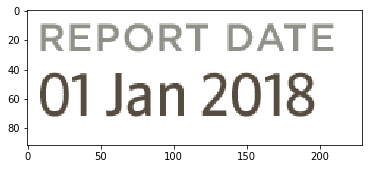

In [21]:
x = ""
for i in range(pd_filter.shape[0]-1):
  if pd_filter["uppercase_text"][pd_filter.index[i]]=="REPORT" and  pd_filter["uppercase_text"][pd_filter.index[i+1]]=="DATE":
    x = min(pd_filter["top"][pd_filter.index[i]],pd_filter["top"][pd_filter.index[i+1]]) -10
    h = max(pd_filter["height"][pd_filter.index[i]],pd_filter["height"][pd_filter.index[i+1]])*4+x +20
    y = min(pd_filter["left"][pd_filter.index[i]],pd_filter["left"][pd_filter.index[i+1]]) -10 
    w = pd_filter["width"][pd_filter.index[i+1]]+ pd_filter["left"][pd_filter.index[i+1]] + 20
    plt.imshow(img[x:h,y:w,:])
    x = pytesseract.image_to_string(img[x:h,y:w,:])
    x = x.split("\n\n")
    if len(x)==2:
      print(x[0] ," : ",x[1])
    else:
      print("Report Date not found")